## Rubin Science Pipelines Kernel Images and Subpixel Offsets

I wrote this notebook to document the behavior of kernel image types in the Rubin Science Pipelines since I found the behavior somewhat non-intuitive.

In [1]:
import lsst
import lsst.afw.image as afw_image
from lsst.meas.algorithms import KernelPsf
from lsst.afw.math import FixedKernel
import lsst.geom as geom

import numpy as np
import galsim
import matplotlib.pyplot as plt

Let's get the version of the weekly I am using.

In [ ]:
!eups list 2>&1 | grep lsst_distrib

lsst_distrib          gdfb3db0272+e66ec9fb54 	current w_latest w_2025_40 setup


In [8]:
!conda list | grep stackvana

stackvana                               0.2025.40             py312h509bfab_0               conda-forge
stackvana-core                          0.2025.40             py312h272f3fb_1               conda-forge
stackvana-core-impl                     0.2025.40             py312h6d1b2d2_1               conda-forge
stackvana-lsst_distrib                  0.2025.40             py312h509bfab_0               conda-forge


## Kernel Image Basics

My (MRB) understanding of kernel images in the Rubin Science Pipelines comes from this snippet of text from the [header](https://github.com/lsst/afw/blob/main/include/lsst/afw/math/Kernel.h):

```text
* The center pixel of a Kernel is at index: (width-1)/2, (height-1)/2. Thus it is centered along
* columns/rows if the kernel has an odd number of columns/rows and shifted 1/2 pixel towards 0 otherwise.
* A kernel should have an odd number of columns and rows unless it is intended to shift an image.
```

Also, note this text in the [header for the PSF classes in afw](https://github.com/lsst/afw/blob/main/include/lsst/afw/detection/Psf.h)

```text
 /**
     *  Return an Image of the PSF, in a form that can be compared directly with star images.
     *
     *  The specified position is a floating point number, and the resulting image will have a Psf
     *  centered on that point when the returned image's xy0 is taken into account.
     *
     *  The returned image is normalized to sum to unity.
     *
     *  @param[in]  position     Position at which to evaluate the PSF.
     *  @param[in]  color        Color of the source for which to evaluate the PSF; defaults to
     *                           getAverageColor().
     *  @param[in]  owner        Whether to copy the return value or return an internal image that
     *                           must be handled with care (see ImageOwnerEnum).
     *
     *  The Psf class caches the most recent return value of computeImage, so repeated calls
     *  with the same arguments will be highly optimized.
     *
     *  @note The real work is done in the virtual private member function Psf::doComputeImage;
     *        computeImage only handles caching and default arguments.
     */
    std::shared_ptr<Image> computeImage(lsst::geom::Point2D position,
                                        image::Color color = image::Color(),
                                        ImageOwnerEnum owner = COPY) const;
```

and this text

```text
/**
     *  Return an Image of the PSF, in a form suitable for convolution.
     *
     *  While the position need not be an integer, the center of the PSF image returned by
     *  computeKernelImage will in the center of the center pixel of the image, which will be
     *  (0,0) when the Image's xy0 is taken into account; this is the same behavior as
     *  Kernel::computeImage().
     *
     *  The returned image is normalized to sum to unity.
     *
     *  @param[in]  position     Position at which to evaluate the PSF.
     *  @param[in]  color        Color of the source for which to evaluate the PSF; defaults to
     *                           getAverageColor().
     *  @param[in]  owner        Whether to copy the return value or return an internal image that
     *                           must be handled with care (see ImageOwnerEnum).
     *
     *  The Psf class caches the most recent return value of computeKernelImage, so repeated calls
     *  with the same arguments will be highly optimized.
     *
     *  @note The real work is done in the virtual private member function Psf::doComputeKernelImage;
     *        computeKernelImage only handles caching and default arguments.
     */
```

Question: What do we expect for a PSF constructed like this

```python
KernelPsf(FixedKernel(afw_image.ImageD(im)))
```

when the input image `im` is an image of the PSF at a location that is not on a pixel center or a pixel edge?

Answer: TL;DR - My understanding is that the `KernelPSF` class can be used to hold such images, but the `computeImage` methods give somewhat surprising results.

## Some Example Code

First we make a PSF with a subpixel offset. We will use an odd shaped image for clarity.

Text(0.5, 1.0, 'PSF with its center offset by (0.15, 0.75) pixels')

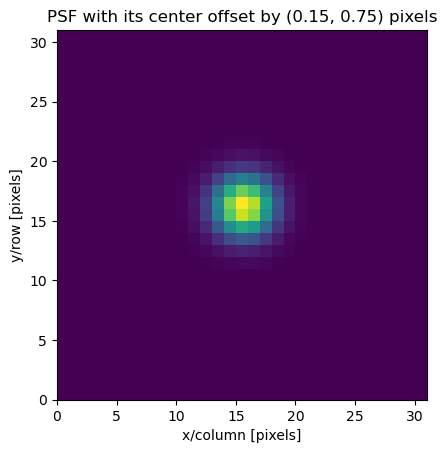

In [44]:
offset = (0.15, 0.75)

im = galsim.Gaussian(fwhm=0.8).drawImage(nx=31, ny=31, scale=0.2, offset=offset).array.astype(np.float64)

fig, axs = plt.subplots()
axs.pcolormesh(im)
axs.set_aspect("equal")
axs.set_xlabel("x/column [pixels]")
axs.set_ylabel("y/row [pixels]")
axs.set_title("PSF with its center offset by (%0.2f, %0.2f) pixels" % offset)

Now we wrap the image into a Rubin PSF.

In [45]:
psf = KernelPsf(FixedKernel(afw_image.ImageD(im)))

Now we draw the PSF with various calls:

- `psf.computeImage(geom.Point2D(*offset))`
- `psf.computeImage(geom.Point2D(0, 0))`
- `psf.computeKernelImage(geom.Point2D(*offset))`
- `psf.computeKernelImage(geom.Point2D(0, 0))`

is the same image?: False
is the same image?: True
is the same image?: True
is the same image?: True


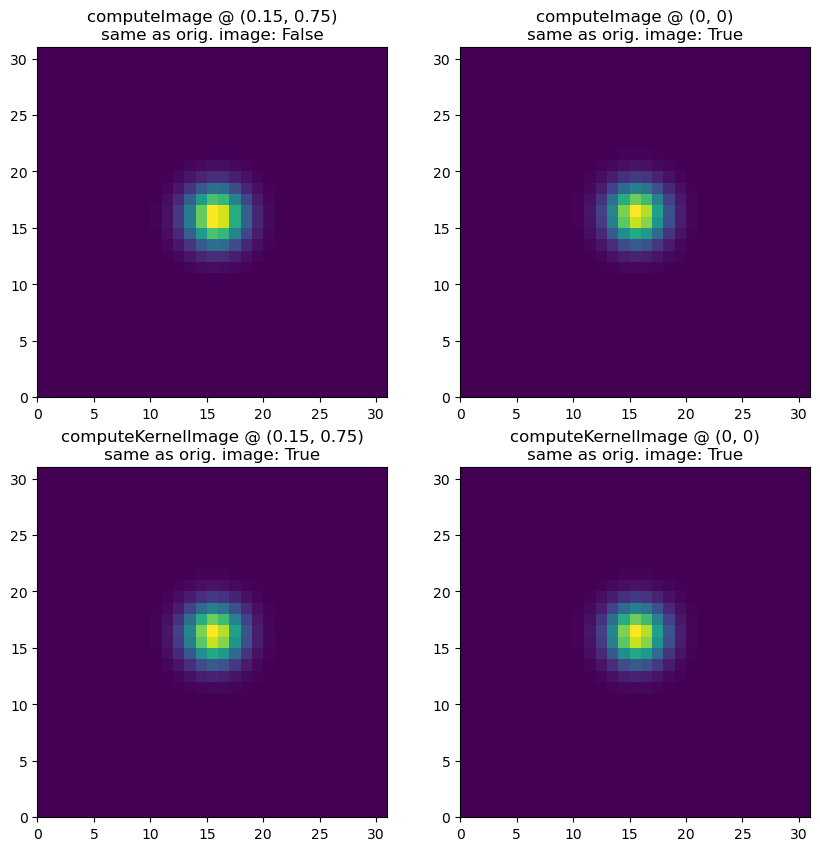

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))


plot_data = [
    (psf.computeImage(geom.Point2D(*offset)), "computeImage @ (%0.2f, %0.2f)" % offset),
    (psf.computeImage(geom.Point2D(0, 0)), "computeImage @ (0, 0)"),
    (psf.computeKernelImage(geom.Point2D(*offset)), "computeKernelImage @ (%0.2f, %0.2f)" % offset),
    (psf.computeKernelImage(geom.Point2D(0, 0)), "computeKernelImage @ (0, 0)"),
]
for ax, (pim, title) in zip(axs.flatten(), plot_data):
    ax.pcolormesh(pim.getArray())
    ax.set_aspect("equal")
    ax.set_title(title + "\nsame as orig. image: %s" % np.allclose(pim.getArray(), im))

    print("is the same image?:", np.allclose(pim.getArray(), im))


The thing I find surprising is the top-left image, where the PSF is now centered on the pixel corner. 

What I think happens in this case is that the original `KernelPSF` class assumes the center of the PSF is at the center of the input image. When you request the PSF at some offset, it then applies the offset. This results in the offset getting applied twice. For an offset of `(0.25, 0.25)` in pixels, you end up with the PSF center at the corners of four pixels (which is an offset of `(0.5, 0.5)`).

The net effect of all of this is that when we have calls like this,


```python
psf_image = psf_obj.computeImage(pos).array
```

we will get the wrong result if the input PSF image is not at a pixel center. We have always used the coadding code this way and so have not found this kind of thing before.

You can find this kind of call in our current coadding code [here](https://github.com/LSSTDESC/descwl_coadd/blob/master/descwl_coadd/coadd.py#L1134) and [here](https://github.com/LSSTDESC/descwl_coadd/blob/master/descwl_coadd/coadd.py#L1182).